In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import v2
from torch.nn import functional as F
from torchvision.transforms.v2.functional import to_pil_image

import json
from PIL import Image
from pathlib import Path
from collections import OrderedDict
import matplotlib.pyplot as plt

In [ ]:
def plot_images(images, bboxes=None, labels=None, class_names=None, figsize=(10, 10)):
    """
    Generated by ChatGPT.
    Plots one or multiple images with optional bounding boxes.

    Args:
        images (torch.Tensor or list of torch.Tensor):
            - A single image (C, H, W) or a batch of images (B, C, H, W).
        bboxes (list of tensors, optional):
            - A list containing tensors of bounding boxes for each image.
            - Each tensor should be (N, 4) where N is the number of boxes.
        labels (list of tensors, optional):
            - A list containing tensors of class labels for each image.
        class_names (list of str, optional):
            - A list mapping class indices to class names.
        figsize (tuple, optional):
            - Figure size for plotting.
    """
    # Ensure images is a list for batch processing
    if isinstance(images, torch.Tensor):
        images = [images] if images.dim() == 3 else list(images)

    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=figsize)

    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for i, (img, ax) in enumerate(zip(images, axes)):
        # Convert tensor to numpy and move to range [0, 1]
        img = to_pil_image(img)  # Convert (C, H, W) to PIL
        ax.imshow(img)

        # Draw bounding boxes if provided
        if bboxes is not None and bboxes[i] is not None:
            for j, box in enumerate(bboxes[i]):
                x_min, y_min, x_max, y_max = map(float, box)
                width, height = x_max - x_min, y_max - y_min

                # Create a rectangle
                rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

                # Add label text if provided
                if labels is not None and class_names is not None:
                    label_idx = int(labels[i][j])  # Convert tensor to integer index
                    ax.text(x_min, y_min - 5, class_names[label_idx], color='white',
                            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.3'))

        ax.axis("off")  # Hide axes

    plt.show()

In [ ]:
# 1. Transforms
# 2. Dataset
# 3. Dataloader
# 4. Splits
# 5. Display pictures

In [ ]:
path = Path("drive/MyDrive/Datasets/pascal-voc-2012/VOC2012/")

In [ ]:
with open(path/'data.json', 'r') as file:
    data = json.load(file)

In [ ]:
d = data[0]
d

{'filename': '2012_002340.jpg',
 'class': ['person', 'person', 'person'],
 'bbox': [['123', '3', '217', '303'],
  ['299', '93', '385', '250'],
  ['218', '81', '294', '259']]}

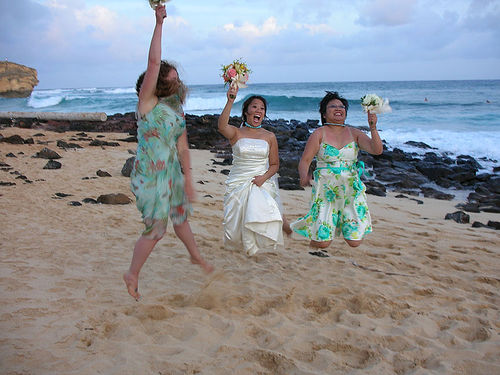

In [ ]:
img = Image.open(path/"JPEGImages"/d["filename"]).convert("RGB")
img

In [ ]:
img_t = v2.ToTensor()(img).unsqueeze(0)
img_t.shape

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([1, 3, 375, 500])

In [ ]:
x_transforms = v2.Compose((
    v2.RandomResizedCrop((300, 300)),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    )
)

In [ ]:
img_t2 = x_transforms(img_t)

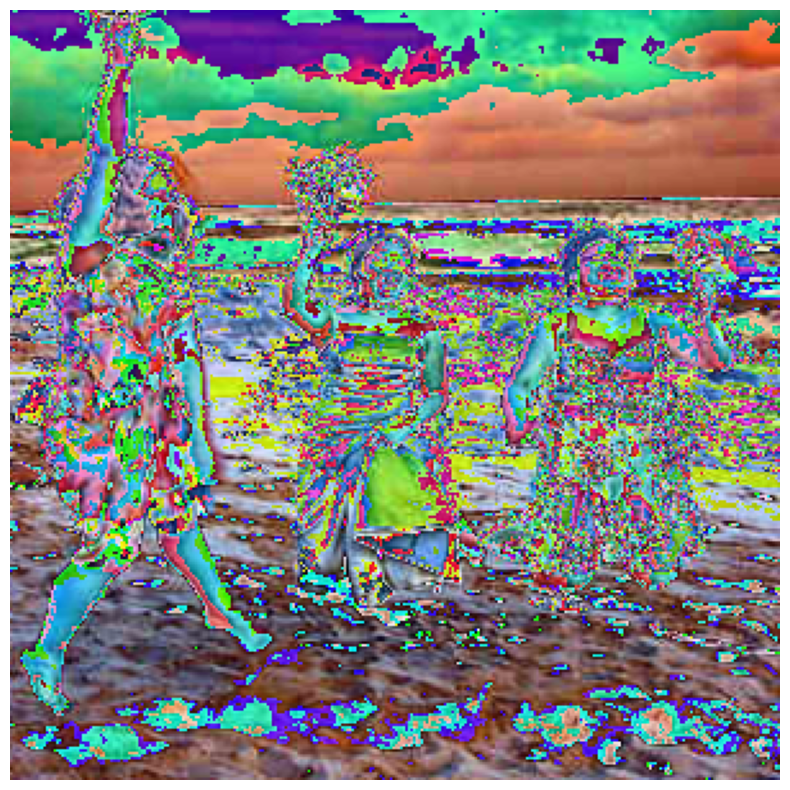

In [ ]:
plot_images(img_t2)


#VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights)
        self.features = self.model.features
        self.avgpool = self.model.avgpool
        self.classifier = self.model.classifier


    def forward(self, x):
        outputs = []
        output = []
        for layer in self.features.children():
            x = layer(x)
            output.append(x)
        outputs.append(output)

        x = self.avgpool(x)
        outputs.append(x)

        output = []
        x = x.view(x.size(0), -1)
        for layer in self.classifier.children():
            x = layer(x)
            output.append(x)
        outputs.append(output)

        return outputs

In [ ]:
vgg16 = VGG16()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 132MB/s]


In [ ]:
outputs = vgg16(img_t2)

In [ ]:
len(outputs)

3

In [ ]:
for i, o in enumerate(outputs[0]): print(i, o.shape)
print(outputs[1].shape)

0 torch.Size([1, 64, 300, 300])
1 torch.Size([1, 64, 300, 300])
2 torch.Size([1, 64, 300, 300])
3 torch.Size([1, 64, 300, 300])
4 torch.Size([1, 64, 150, 150])
5 torch.Size([1, 128, 150, 150])
6 torch.Size([1, 128, 150, 150])
7 torch.Size([1, 128, 150, 150])
8 torch.Size([1, 128, 150, 150])
9 torch.Size([1, 128, 75, 75])
10 torch.Size([1, 256, 75, 75])
11 torch.Size([1, 256, 75, 75])
12 torch.Size([1, 256, 75, 75])
13 torch.Size([1, 256, 75, 75])
14 torch.Size([1, 256, 75, 75])
15 torch.Size([1, 256, 75, 75])
16 torch.Size([1, 256, 37, 37])
17 torch.Size([1, 512, 37, 37])
18 torch.Size([1, 512, 37, 37])
19 torch.Size([1, 512, 37, 37])
20 torch.Size([1, 512, 37, 37])
21 torch.Size([1, 512, 37, 37])
22 torch.Size([1, 512, 37, 37])
23 torch.Size([1, 512, 18, 18])
24 torch.Size([1, 512, 18, 18])
25 torch.Size([1, 512, 18, 18])
26 torch.Size([1, 512, 18, 18])
27 torch.Size([1, 512, 18, 18])
28 torch.Size([1, 512, 18, 18])
29 torch.Size([1, 512, 18, 18])
30 torch.Size([1, 512, 9, 9])
torch.S

In [ ]:
for i, l in enumerate(list(vgg16.features.children())): print(i, l)
print(vgg16.model.avgpool)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [ ]:
nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True)(torch.randn([1, 256, 75, 75])).shape

torch.Size([1, 256, 38, 38])

In [ ]:
nn.MaxPool2d(kernel_size=2, stride=2, padding=0)(torch.randn([1, 512, 38, 38])).shape

torch.Size([1, 512, 19, 19])

In [ ]:
nn.MaxPool2d(kernel_size=3, stride=1, padding=1)(torch.randn([1, 512, 19, 19])).shape

torch.Size([1, 512, 19, 19])

In [ ]:
z = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)(torch.randn([1, 512, 19, 19]))

In [ ]:
z = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)

In [ ]:
vgg16.classifier[0].weight.shape

torch.Size([4096, 25088])

In [ ]:
z.weight.shape, z.bias.shape

(torch.Size([1024, 512, 3, 3]), torch.Size([1024]))

In [ ]:
1024*512*3*3, 4096*25088

(4718592, 102760448)

In [ ]:
nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=1, stride=1, padding=0)(torch.randn([1, 1024, 19, 19])).shape

torch.Size([1, 1024, 19, 19])

In [ ]:
a = nn.Conv2d(in_channels=1024, out_channels=256, kernel_size=1, stride=1, padding=0)(torch.randn([1, 1024, 19, 19]))
b = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1)(z)
a.shape, b.shape

(torch.Size([1, 256, 19, 19]), torch.Size([1, 512, 10, 10]))

In [ ]:
c = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=1, stride=1, padding=0)(b)
d = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)(c)
c.shape, d.shape

(torch.Size([1, 128, 10, 10]), torch.Size([1, 256, 5, 5]))

In [ ]:
e = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0)(d)
f = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)(e)
e.shape, f.shape

(torch.Size([1, 128, 5, 5]), torch.Size([1, 256, 3, 3]))

In [ ]:
g = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1, stride=1, padding=0)(f)
h = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0)(g)
g.shape, h.shape

(torch.Size([1, 128, 3, 3]), torch.Size([1, 256, 1, 1]))

In [ ]:
a = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)(torch.randn([1, 64, 300, 300]))
nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))(a).shape

torch.Size([1, 128, 150, 150])

In [ ]:
nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))(torch.randn([1, 64, 300, 300])).shape

torch.Size([1, 128, 150, 150])

In [ ]:
for i, o in enumerate(outputs[2]): print(i, o.shape)

0 torch.Size([1, 4096])
1 torch.Size([1, 4096])
2 torch.Size([1, 4096])
3 torch.Size([1, 4096])
4 torch.Size([1, 4096])
5 torch.Size([1, 4096])
6 torch.Size([1, 1000])


In [ ]:
for i, l in enumerate(list(vgg16.classifier.children())): print(i, l)

0 Linear(in_features=25088, out_features=4096, bias=True)
1 ReLU(inplace=True)
2 Dropout(p=0.5, inplace=False)
3 Linear(in_features=4096, out_features=4096, bias=True)
4 ReLU(inplace=True)
5 Dropout(p=0.5, inplace=False)
6 Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
nn.Conv2d(in_channels=512, out_channels=1024 ,kernel_size=3, stride=3)(torch.randn([1, 512, 7, 7])).shape

torch.Size([1, 1024, 2, 2])

In [ ]:
a = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)(torch.randn([1, 512, 18, 18]))
a.shape

torch.Size([1, 512, 18, 18])

#Creating Arch

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size=3, stride=1, padding=0, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=kernel_size,
                              stride=stride, padding=padding, **kwargs)
        self.relu = nn.ReLU()

        nn.init.xavier_uniform_(self.conv.weight)
        if self.conv.bias is not None:
            nn.init.zeros_(self.conv.bias)

    def forward(self, x):
        return self.relu(self.conv(x))


In [ ]:
nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=0)(torch.randn([1, 512, 18, 18])).shape

torch.Size([1, 1024, 16, 16])

In [ ]:
class SSDArch(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights)

        _, _, maxpool3_pos, maxpool4_pos, _ = (i for i, layer in
                                                enumerate(self.model.features) if isinstance(layer, nn.MaxPool2d))

        self.model.features[maxpool3_pos].ceil_mode = True

        self.conv4_3 = self.model.features[:maxpool4_pos]

        self.conv7 = nn.Sequential(
                        *self.model.features[maxpool4_pos:-1],
                        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                        ConvBlock(in_channels=512, out_channels=1024, kernel_size=3, padding=6, dilation=6),
                        ConvBlock(in_channels=1024, out_channels=1024, kernel_size=1),
                    )
        self.scale_weight = nn.Parameter(torch.ones((1, 512, 1, 1))) * 20


        self.extra = nn.ModuleList([
                    nn.Sequential(
                        OrderedDict([
                        ('conv8_1', ConvBlock(in_channels=1024, out_channels=256, kernel_size=1)),
                        ('conv8_2', ConvBlock(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1))
                    ])),

                    nn.Sequential(
                        OrderedDict([
                        ('conv9_1', ConvBlock(in_channels=512, out_channels=128, kernel_size=1)),
                        ('conv9_2', ConvBlock(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1))
                    ])),

                    nn.Sequential(
                        OrderedDict([
                        ('conv10_1', ConvBlock(in_channels=256, out_channels=128, kernel_size=1)),
                        ('conv10_2', ConvBlock(in_channels=128, out_channels=256, kernel_size=3))
                    ])),

                    nn.Sequential(
                        OrderedDict([
                        ('conv11_1', ConvBlock(in_channels=256, out_channels=128, kernel_size=1)),
                        ('conv11_2', ConvBlock(in_channels=128, out_channels=256, kernel_size=3))
                    ]))
                ])


    def forward(self, x):
        outputs = []
        x = self.conv4_3(x)
        outputs.append(F.normalize(x) * self.scale_weight) # L2 normaliztion with scale weight

        x = self.conv7(x)
        outputs.append(x)

        for layer in self.extra:
            x = layer(x)
            outputs.append(x)

        layer_names = ["conv4_3", "conv7"] + [f"conv{i+8}_2" for i in range(len(self.extra))]

        return OrderedDict(zip(layer_names, outputs))


In [ ]:
# Conv4_2
# Conv7
# Conv8_2
# Conv9_2
# Conv10_2
# Conv11_2

In [ ]:
(0.7/5)*0

0.0

In [ ]:
arch = SSDArch()

In [ ]:
o = arch(img_t2)

In [ ]:
for k, v in o.items(): print(f"{k}: {v.shape}")

conv4_3: torch.Size([1, 512, 38, 38])
conv7: torch.Size([1, 1024, 19, 19])
conv8_2: torch.Size([1, 512, 10, 10])
conv9_2: torch.Size([1, 256, 5, 5])
conv10_2: torch.Size([1, 256, 3, 3])
conv11_2: torch.Size([1, 256, 1, 1])


In [ ]:
list(o.values())[0].shape[1:] == torch.Size([512, 38, 38])

True

In [ ]:
arch.till_conv4_3(img_t2).shape

In [ ]:
aa = torch.ones((1, 512, 1, 1)) * 20
aa.shape

torch.Size([1, 512, 1, 1])

In [ ]:
zzz = torch.rand([1, 512, 38, 38])
F.normalize(aa * zzz).shape

torch.Size([1, 512, 38, 38])

In [ ]:
[i for i, j in enumerate(arch.model.features) if isinstance(j, nn.MaxPool2d)]

[4, 9, 16, 23, 30]

In [ ]:
[(i,j) for i,j in enumerate(arch.model.features)]

[(0, Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (1, ReLU(inplace=True)),
 (2, Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (3, ReLU(inplace=True)),
 (4,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (5, Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (6, ReLU(inplace=True)),
 (7, Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (8, ReLU(inplace=True)),
 (9,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 (10, Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (11, ReLU(inplace=True)),
 (12, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (13, ReLU(inplace=True)),
 (14, Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 (15, ReLU(inplace=True)),
 (16,
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)),
 (17, Conv2d(256, 512, kernel_size=(3, 3)

In [ ]:
1024*19*19

369664

In [ ]:
512*7*7

25088

In [ ]:
1024*2*2

4096

In [ ]:
zz = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=6, dilation=6)
zz(torch.randn([1, 512, 19, 19])).shape

torch.Size([1, 1024, 19, 19])

In [ ]:
zz.weight.shape

torch.Size([1024, 512, 3, 3])

In [ ]:
arch.model.classifier[-1].weight.shape

torch.Size([1000, 4096])